Rock - Paper - Scissors CNN Classifier

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten,Input, Conv2D, MaxPooling2D

In [4]:
seed = 17
image_size = (200, 300)
batch_size = 710
classes = ("paper", "rock", "scissors")
validation_split = 0.2

Preprocessing
Explore the dataset thoroughly and provide a summary of your observations.
Perform necessary preprocessing steps:
    - [x] Explore and plot the data
    - [x] Image resizing.
    - [x] Image normalization.
    - [x] Optionally, data augmentation techniques.
    - [x] Splitting the data into training and test sets appropriately.

In [5]:
initial_train_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/train",
    image_size=image_size,
    shuffle=True,
    seed=seed,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/validation",
    image_size=image_size,
    shuffle=False,
    seed=seed,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/test",
    image_size=image_size,
    shuffle=False,
    seed=seed,
)

Found 1531 files belonging to 3 classes.
Found 437 files belonging to 3 classes.
Found 220 files belonging to 3 classes.


In [6]:
def visualize_dataset(train_ds, classes):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(classes[int(labels[i])])
            plt.axis("off")

2025-07-13 17:24:15.069653: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


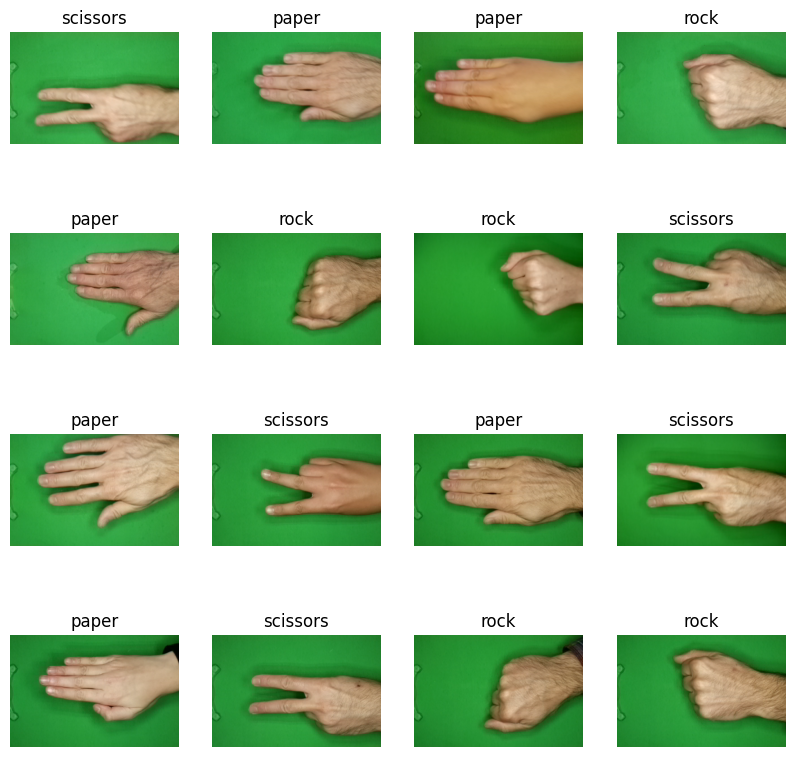

In [7]:
visualize_dataset(initial_train_ds, classes)

In [8]:
# data augmentation
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomBrightness(0.2, seed=seed),
    layers.RandomZoom(0.2, seed=seed),
    layers.RandomContrast(0.4, seed=seed),
    layers.RandomCrop(height=200, width=300, seed=seed),
])

augmented_train_ds = initial_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


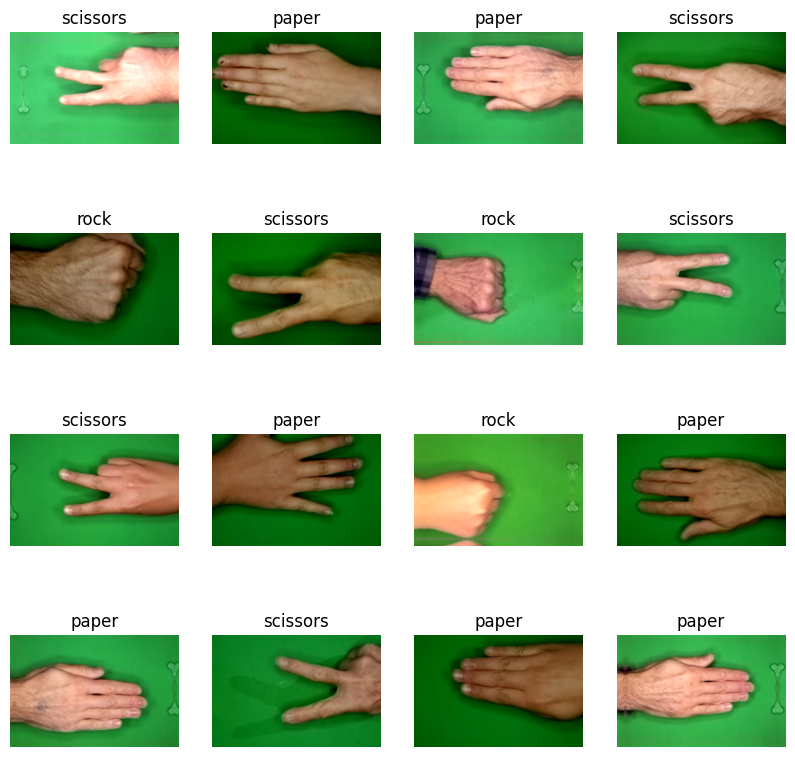

In [29]:
visualize_dataset(augmented_train_ds, classes)

### Image normalization.

In [14]:
# normalization
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = augmented_train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [15]:
# convert datasets to numpy arrays for further processing
def dataset_to_numpy(ds):
    X, y = [], []
    for images, labels in ds:
        X.append(images.numpy())
        y.append(labels.numpy())
    return tf.concat(X, axis=0), tf.concat(y, axis=0)

X_train, y_train = dataset_to_numpy(train_ds)
X_validation, y_validation = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)

In [16]:
# are the datasets balanced?
print(np.unique(y_train,return_counts=True),np.unique(y_validation,return_counts=True))

(array([0, 1, 2], dtype=int32), array([498, 508, 525])) (array([0, 1, 2], dtype=int32), array([142, 145, 150]))


The dataset is not imbalanced since the differences between the occurance of classes is not big.

Simple model
- one convolutional layer, 32 fiters 3x3 grid
- maxpooling 2x2
- hidden layer NN with 512 neurons
- softmax

In [17]:
def build_simple_model(hp):
    model = Sequential()
    model.add(Input(shape=(200, 300, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(
        filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
    ))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense( 
        units = hp.Int('dense_units', min_value=128, max_value=512, step=128), 
        activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4], default=1e-3)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Tuning the model
Tuning params
 - Number of filters for the Convolutional Layer
 - Number of units for the densely-connected NN layer
 - Learning rate for the Optimizer

In [19]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_simple_model,
    objective='val_accuracy',
    max_epochs=5,
    max_retries_per_trial=0,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='cnn_tuning'
)


Reloading Tuner from tuning_results/cnn_tuning/tuner0.json


In [ ]:

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_early])

In [23]:
best_model_1 = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_learning_rate = best_hyperparams.get('learning_rate')

print("Best Conv filters:", best_hyperparams.get('conv_filters'))
print("Best Dense units:", best_hyperparams.get('dense_units'))
print("Best Learning rate:", best_hyperparams.get('learning_rate'))

best_model_1.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Conv filters: 64
Best Dense units: 512
Best Learning rate: 0.0001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 296, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 928256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   475,267,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,288,515 (1.77 GB)

 Trainable params: 475,288,515 (1.77 GB)

 Non-trainable params: 0 (0.00 B)

### Used tuned params 

In [24]:
best_model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 296, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 928256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   475,267,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,288,515 (1.77 GB)

 Trainable params: 475,288,515 (1.77 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model_1.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=10,
    batch_size=32
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.8033 - loss: 0.4730 - val_accuracy: 0.3432 - val_loss: 1.2711
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 436s 9s/step - accuracy: 0.9296 - loss: 0.2827 - val_accuracy: 0.3432 - val_loss: 1.3192
Epoch 3/10
22/48 ━━━━━━━━━━━━━━━━━━━━ 3:50 9s/step - accuracy: 0.9369 - loss: 0.2011

In [ ]:
real = np.argmax(y_test,axis=1)
model_saved = best_model_1
y_pred = model_saved.predict(X_test)
pred = np.argmax(y_pred,axis=1)
print(pred)

### Provide visualizations of training curves (loss and accuracy)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

def plot_training_curves(fitted_model):
    acc = fitted_model.history['accuracy']
    val_acc = fitted_model.history['val_accuracy']
    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()
    
def test_results(model, X_test, y_test, classes):
    y_pred = model.predict(X_test)
    pred = np.argmax(y_pred, axis=1)
    
    plot_training_curves(model)
    plot_confusion_matrix(np.argmax(y_test, axis=1), pred, classes)
    plot_classification_report(np.argmax(y_test, axis=1), pred, classes, digits=6)



In [ ]:
test_results(best_model_1, X_test, y_test, classes)